In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision

import PIL
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

import os
import re

from tqdm.auto import tqdm

In [2]:
import pandas as pd

In [3]:
from fold_actions import point_line_symmetry, matrix_line_symmetry, read_cloth_image, fold_action_max

In [4]:
f_path = "data/fold/"

In [5]:
IMAGE_SIZE = 28

In [6]:
USE_CUDA = True

In [7]:
class ClothImages(Dataset):
    def __init__(self, folder_path,  transforms=None, revert=False):
        self.revert = revert
        self.data_root_folder = folder_path
        self.image_list, self.action_list  = self.load_image_list(self.data_root_folder)
        self.transforms = transforms
        
    def load_image_list(self, folder_path):
        image_list = []
        action_list = None
        for dress_folder in os.listdir(folder_path):
            if dress_folder.endswith(".csv"):
                action_list = pd.read_csv(folder_path + dress_folder)
            else:
                dress_image_list = []
                image_folder = os.path.join(folder_path, dress_folder)
                order_image_list = os.listdir(image_folder)
                if self.revert:
                    order_image_list = order_image_list[::-1]
                for file_name in order_image_list:
                    #image_list.append(os.path.join(image_folder, file_name))
                    single_image_path = os.path.join(image_folder, file_name)
                    dress_image_list.append(single_image_path)

                image_list.append(dress_image_list)
        
        return image_list, action_list
    
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, index):
        img_list = [] 
        for dress_image_path in self.image_list[index]:
            #print(dress_image_path)
            # Open image
            img = PIL.Image.open(dress_image_path).convert("L")
            img = PIL.ImageOps.invert(img)
            #img = resize(img,(IMAGE_SIZE,IMAGE_SIZE))
            if self.transforms is not None:
                img = self.transforms(img)
            
            img_list.append(img)
            
        if self.transforms is None:
            return img_list
        
        img_tensor = torch.stack(img_list,dim=0)
        return img_tensor
        

In [8]:
# transforms = torchvision.transforms.Compose([
#     torchvision.transforms.Resize((IMAGE_SIZE,IMAGE_SIZE), interpolation= PIL.Image.NEAREST),
#     torchvision.transforms.RandomAffine(degrees = 90, translate = (0.2,0.2), scale = (0.6,1)),
#     #torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
#     torchvision.transforms.RandomHorizontalFlip(),
#     torchvision.transforms.RandomVerticalFlip(),
#     # torchvision.transforms.RandomRotation(20, resample=PIL.Image.BILINEAR)
#     torchvision.transforms.ToTensor(),
# ])

In [9]:
ci = ClothImages(f_path, revert=False)

In [10]:
def conv3x3(in_channels, out_channels, **kwargs):
    # The convolutional layers (for feature extraction) use standard layers from
    # `torch.nn`, since they do not require adaptation.
    # See `examples/maml/model.py` for comparison.
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, **kwargs),
        nn.BatchNorm2d(out_channels, momentum=1., track_running_stats=False),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )

In [11]:
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self, in_channels, out_features, hidden_size=64):
        super(ConvolutionalNeuralNetwork, self).__init__()
        self.in_channels = in_channels
        self.out_features = out_features
        self.hidden_size = hidden_size

        self.features = nn.Sequential(
            conv3x3(in_channels, hidden_size),
            conv3x3(hidden_size, hidden_size),
            conv3x3(hidden_size, hidden_size),
            conv3x3(hidden_size, hidden_size)
        )

        self.linear_aesthetics = nn.Sequential(
            nn.Linear(hidden_size, out_features),
            nn.Sigmoid(),
        )

    def forward(self, inputs, params=None):
        features = self.features(inputs)
        #print(features.shape)
        features = features.view((features.size(0), -1))
        #print(features.shape)
        scores = self.linear_aesthetics(features)
        return scores

In [ ]:
model = ConvolutionalNeuralNetwork(1, 1, hidden_size=64)

In [ ]:
if USE_CUDA and torch.cuda.is_available():
    model = model.cuda()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [18]:
transforms_after = torchvision.transforms.Compose([
    torchvision.transforms.Resize((IMAGE_SIZE,IMAGE_SIZE),interpolation = PIL.Image.NEAREST),
    torchvision.transforms.RandomAffine(degrees = 90, translate = (0.2,0.2), scale = (0.6,1)),
    torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
    torchvision.transforms.ToTensor(),
])


# Train

In [20]:
def calculate_image_score(cloth_img: np.array, transform_img, model_img, use_cuda = False):
    img = Image.fromarray(np.uint8(cloth_img * 255), 'L')
    img_t = transform_img(img)
    if use_cuda:
        img_t = img_t.to("cuda")
    img_t_score = model_img(img_t.unsqueeze(0))
    
    return img_t_score

In [16]:
epochs = 100

In [ ]:
for epoch in range(epochs):
    loss_epoch = []
    for i in tqdm(range(len(ci.image_list))):
        for j in range(len(ci.image_list[i]) - 1):
            oriImage = read_cloth_image(ci.image_list[i][j], show_image=False)
            nextImage = read_cloth_image(ci.image_list[i][j + 1], show_image=False)

            curA, curS, curImage = fold_action_max(oriImage, model, transforms_after, use_cuda=USE_CUDA)

            loss = - calculate_image_score(nextImage, transforms_after, model, USE_CUDA) \
                    + calculate_image_score(curImage, transforms_after, model, USE_CUDA)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_epoch.append(loss.item())
            
            #print(loss.item())
    print(np.mean(loss_epoch))

In [ ]:
torch.save(model, "record/fold_me_irl.pth")

In [ ]:
# img0 = read_cloth_image(ci.image_list[0][0])
# img1 = read_cloth_image(ci.image_list[0][1])

# oriImage = img0

# curA, curS, curImage = fold_action_max(oriImage, model, transforms_after)

# # calculate_image_score(img1, transforms_after, model)

# # calculate_image_score(curImage, transforms_after, model)

# loss = - calculate_image_score(img1, transforms_after, model) + calculate_image_score(curImage, transforms_after, model)

# optimizer.zero_grad()
# loss.backward()
# optimizer.step()

In [12]:
model2 = ConvolutionalNeuralNetwork(1, 1, hidden_size=64)

In [14]:
pretrained_dict = torch.load("10_27.pth")

model2_dict = model2.state_dict()
# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model2_dict}
# 2. overwrite entries in the existing state dict
model2_dict.update(pretrained_dict) 
# 3. load the new state dict
model2.load_state_dict(model2_dict)

if torch.cuda.is_available():
    model2 = model2.cuda()

optimizer2 = torch.optim.Adam(model2.parameters(), lr=1e-3)


In [21]:
for epoch in tqdm(range(epochs)):
    loss_epoch = []
    for i in range(len(ci.image_list)):
        for j in range(len(ci.image_list[i]) - 1):
            oriImage = read_cloth_image(ci.image_list[i][j], show_image=False)
            nextImage = read_cloth_image(ci.image_list[i][j + 1], show_image=False)

            curA, curS, curImage = fold_action_max(oriImage, model2, transforms_after, use_cuda=USE_CUDA)

            loss = - calculate_image_score(nextImage, transforms_after, model2, USE_CUDA) \
                    + calculate_image_score(curImage, transforms_after, model2, USE_CUDA)

            optimizer2.zero_grad()
            loss.backward()
            optimizer2.step()
            
            loss_epoch.append(loss.item())
            
            #print(loss.item())
    print(np.mean(loss_epoch))

-0.039847165087444916
-0.022954817602617875
-0.031979949575745396
-0.006837024146484004
-0.09009100289808379
-0.10022356950988372
0.00658157544158813
-0.2774198729958799
0.00977611443441775
-0.01894528501563602
-0.0023385658860206604
0.013186122808191512
0.0005447806583510505
0.00022645129097832573
-1.644591490427653e-05
-0.00017841822571224638
0.00021112793021731905
0.0002344739105966356
0.00045321881771087646
0.0001265952984491984
-7.231119606229995e-05
3.848473230997721e-05
-0.00010244548320770264
5.668981207741631e-05
-0.0005213146408398946
-0.00018046547969182333
-0.0002911951806810167
-0.0002224743366241455
-0.0005182474851608276
-0.00016880366537306044
-0.00037504401471879747
0.0004076436161994934
-0.0010745301842689514
-0.0003997774587737189
-0.0002064224746492174
-0.03508132261534532
-0.06460794814241429
0.008196556285030156
0.007419454712362494
-1.3572957767691049e-05
-0.0002671883190083059
-0.0012449729644382994
0.002121790316272786
-0.0008873952978723941
0.00062689615272878

In [22]:
torch.save(model2, "record/fold_me_irl_pre.pth")

# Test 

In [27]:
model = torch.load("record/fold_me_irl.pth")
model2 = torch.load("record/fold_me_irl_pre.pth")

In [28]:
model.eval()
model2.eval()

ConvolutionalNeuralNetwork(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=1.0, affine=True, track_running_stats=False)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=1.0, affine=True, track_running_stats=False)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=1.0, affine=True, track_running_stats=False)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Conv2d(64, 64, 

In [29]:
model = model.cpu()
model2 = model2.cpu()

In [30]:
transforms_test= torchvision.transforms.Compose([
    torchvision.transforms.Resize((IMAGE_SIZE,IMAGE_SIZE),interpolation = PIL.Image.NEAREST),
    torchvision.transforms.RandomAffine(degrees = 0, translate = (0.0,0.0), scale = (0.8,0.8)),
    torchvision.transforms.ToTensor(),
])

In [ ]:
cloth_folder = "C:\\Users\\Yizhou Zhao\\Desktop\\AI\\validation\\"

In [ ]:
os.listdir(cloth_folder)

In [ ]:
for file_name in os.listdir(cloth_folder):
    if file_name.endswith(".png"):
        print("-----------\n",file_name)
        cloth_name = file_name

        cloth_file = cloth_folder + cloth_name

        cloth_img = read_cloth_image(cloth_file)

        #plt.imshow(cloth_img, cmap="gray")

        img = Image.fromarray(np.uint8(cloth_img * 255) , 'L')

        t3 = transforms_test(img)

        print(t3.shape)

        plt.imshow(t3[0].data.numpy(), cmap="gray")

        print(model(t3.unsqueeze(0)).item(), model2(t3.unsqueeze(0)).item())

# Rank

In [35]:
index = 20

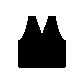

tensor([[0.0001]], grad_fn=<SigmoidBackward>)
tensor([[0.0016]], grad_fn=<SigmoidBackward>)


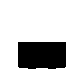

tensor([[0.0001]], grad_fn=<SigmoidBackward>)
tensor([[0.0423]], grad_fn=<SigmoidBackward>)


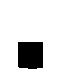

tensor([[0.9185]], grad_fn=<SigmoidBackward>)
tensor([[0.9649]], grad_fn=<SigmoidBackward>)


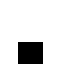

tensor([[0.9955]], grad_fn=<SigmoidBackward>)
tensor([[0.9760]], grad_fn=<SigmoidBackward>)


In [36]:
for j in range(len(ci.image_list[index])):
    cloth_img = read_cloth_image(ci.image_list[index][j])
    print(calculate_image_score(cloth_img, transforms_test, model))
    print(calculate_image_score(cloth_img, transforms_test, model2))